# Определение возраста покупателей - компьютерное зрение

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

Предоставлен набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке **/datasets/faces/**.

В вашем распоряжении одна папка со всеми изображениями (**/final_files**) и CSV-файл **labels.csv** с двумя колонками: **file_name** и **real_age**.

Извлечь данные из папки вам поможет новый метод ImageDataGenerator:

**flow_from_dataframe(dataframe, directory, ...)**.

**Задание 1**
Проведите исследовательский анализ данных:
- Посмотрите на размер выборки.
- Постройте график распределения возраста в выборке.
- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
- Сделайте выводы о том, как результаты исследования повлияют на обучение модели.


## Исследовательский анализ данных

Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Открываем файл с разметкой

In [ ]:
df= pd.read_csv("/datasets/faces/labels.csv")
print("Размер выборки:", df.shape)

Размер выборки: (7591, 2)


In [ ]:
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В файле 7591 строка, указано имя файла и возраст человека. Пропусков нет. Данных достаточно мало, поэтому для улучшения обучения необходимо будет использовать аугментацию - отражения изображения, повороты, лучше использовать предобученную сеть, например ImageNet.

In [ ]:
df.duplicated().sum()

0

Дубликатов в файле нет. Посмотрим как распределились возраста в выборке

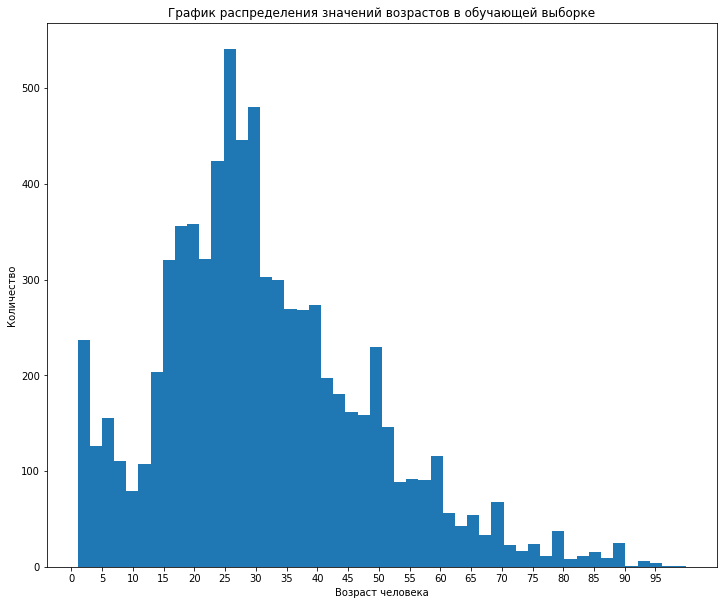

In [ ]:
plt.figure(figsize=(12,10))
plt.title("График распределения значений возрастов в обучающей выборке")
plt.xlabel('Возраст человека')
plt.ylabel('Количество')
plt.xticks(range(0,100, 5))
plt.hist(df['real_age'], bins = 50)
plt.show()

График имеет нормальное распределение, со сдвигом влево (пожилых 70+ значительно меньше, нежели малышей до 7 лет), явных выбросов нет.

Максимальное количество фотографий приходится на возраст 22 - 32 года, в среднем основная масса приходится на 15-50 лет.

Посмотрим на примеры изображений, соответствующих данной выборке:

Found 7591 validated image filenames.


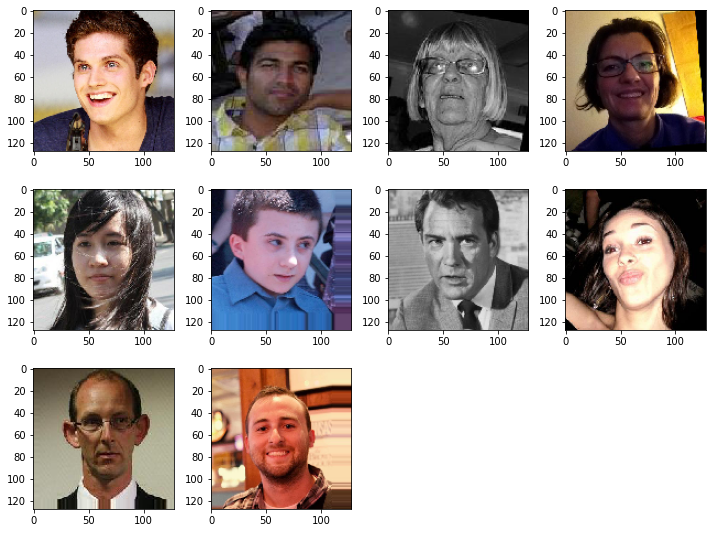

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe = df,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',
    seed=12)
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()

Фотографии очень разные, с неоднородным фоном, разными позами, направлением взгляда, выражением лиц и т.п. В связи с этим и с учетом количество фотографий в выборке становится очевидной необходимость использования предобученной сети.

### Вывод ###


В файле разметка по 7,5т изображений людей разных возрастов.
 Возраста распределены нормально- большинство фото относятся к самому "активному покупательскому возрасту" - с 15 до 55 лет.

 Было бы отлично иметь немного больше фотографий просевших диапазонов и в целом бОльшее количество фотографий, т.к. они не похожи, имеют разнородный фон, позы, выражения лиц и качество.

 В связи с этим нам следуюет использовать предобученную сеть - напрмиер ResNet50 и провести аугментацию изображений для повышения качества обучения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow  = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='validation')

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 106s - loss: 233.0051 - mae: 11.2804 - val_loss: 577.6686 - val_mae: 19.0083
Epoch 2/20
356/356 - 81s - loss: 108.2620 - mae: 7.9615 - val_loss: 137.5634 - val_mae: 8.8276
Epoch 3/20
356/356 - 56s - loss: 93.4865 - mae: 7.3833 - val_loss: 94.0445 - val_mae: 7.1217
Epoch 4/20
356/356 - 53s - loss: 72.7348 - mae: 6.5371 - val_loss: 109.5511 - val_mae: 7.9166
Epoch 5/20
356/356 - 53s - loss: 62.1307 - mae: 6.0178 - val_loss: 97.7247 - val_mae: 7.7101
Epoch 6/20
356/356 - 53s - loss: 53.2355 - mae: 5.5870 - val_loss: 83.2626 - val_mae: 6.7982
Epoch 7/20
356/356 - 40s - loss: 46.5846 - mae: 5.2465 - val_loss: 131.3461 - val_mae: 8.5598
Epoch 8/20
356/356 - 38s - loss: 40.2373 - mae: 4.8826 - val_loss: 94.6908 - val_mae: 7.5670
Epoch 9/20
356/356 - 38s - loss: 36.5154 - mae: 4.6251 - val_loss: 79.8188 - val_mae: 6.6706
Epoch 10/20
356/356 - 38s - loss: 31.8189 - mae: 4.3124 - val_loss: 76.1858 - val_mae: 6.4546
Epoch 11/20
356/356 - 38s - loss: 27.8036 - mae: 4.0055 - val_loss: 136.6958 - val_mae: 9.3659
Epoch 12/20
356/356 - 38s - loss: 26.4390 - mae: 3.9372 - val_loss: 81.7166 - val_mae: 6.6897
Epoch 13/20
356/356 - 38s - loss: 23.6017 - mae: 3.7293 - val_loss: 84.2269 - val_mae: 6.7648
Epoch 14/20
356/356 - 38s - loss: 20.8906 - mae: 3.5019 - val_loss: 79.6421 - val_mae: 6.6583
Epoch 15/20
356/356 - 38s - loss: 19.8177 - mae: 3.3918 - val_loss: 73.9831 - val_mae: 6.3928
Epoch 16/20
356/356 - 38s - loss: 18.1377 - mae: 3.2636 - val_loss: 67.3945 - val_mae: 6.1463
Epoch 17/20
356/356 - 38s - loss: 18.0464 - mae: 3.2492 - val_loss: 69.9824 - val_mae: 6.2799
Epoch 18/20
356/356 - 38s - loss: 17.1022 - mae: 3.1418 - val_loss: 76.9241 - val_mae: 6.7178
Epoch 19/20
356/356 - 38s - loss: 18.6973 - mae: 3.3155 - val_loss: 75.8656 - val_mae: 6.4187
Epoch 20/20
356/356 - 38s - loss: 17.4630 - mae: 3.1997 - val_loss: 72.7271 - val_mae: 6.2465

119/119 - 9s - loss: 72.7271 - mae: 6.2465
Test MAE: 6.2465

```

## Анализ обученной модели

Обученная модель показала отличный результат по MAE = 6,2465, что даже лучше необходимого.
Модель в процессе не переобучилась, несмотря на количество слоев (в отличие от меня, я точно переобучилась ))).

Благодаря предобученной чети и процесс обучения был быстрым и получены такие отличные результаты - вряд ли с таким количеством и качеством исходных данных без использования предобученной нейронной сети ResNet50 можно было бы рассчитывать на подобный результат.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы